In [1]:
import pandas as pd  
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as plt  
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, MonthLocator, DayLocator
from matplotlib.dates import drange, DateLocator, DateFormatter
from matplotlib.dates import HourLocator, MinuteLocator, SecondLocator
from datetime import datetime
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
%matplotlib inline


In [2]:
pw2014_ini=pd.read_csv('homeF_2014_merge_2.csv')
pw2015_ini=pd.read_csv('homeF_2015_merge_2.csv')

In [3]:
power = pd.concat([pw2014_ini,pw2015_ini],axis=0,ignore_index=True)

In [4]:
power.head()

,Date & Time,Usage [kW],Generation [kW],WaterHeater [kW],Solar [kW],Refrigerator [kW],Microwave [kW],Furnace [kW],WaterHeater3 [kW],WaterHeater2 [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,2014-01-01 00:00:00,0.977402,0.009264,0.296840,0.009264,0.059256,0.002800,0.008474,0.000531,0.020002,...,10.0,Clear,8.33,1023.40,12.83,0.0,284.0,0.0,3.36,0.0
1,2014-01-01 00:15:00,0.377746,0.009904,0.063231,0.009904,0.003734,0.002914,0.008633,0.000471,0.009642,...,10.0,Clear,8.33,1023.40,12.83,0.0,284.0,0.0,3.36,0.0
2,2014-01-01 00:30:00,0.420196,0.010133,0.001511,0.010133,0.121228,0.002630,0.008059,0.000044,0.000011,...,10.0,Clear,8.33,1023.40,12.83,0.0,284.0,0.0,3.36,0.0
3,2014-01-01 00:45:00,0.290328,0.010029,0.000058,0.010029,0.016986,0.002910,0.008511,0.000411,0.000202,...,10.0,Clear,8.33,1023.40,12.83,0.0,284.0,0.0,3.36,0.0
4,2014-01-01 01:00:00,0.307616,0.010038,0.000127,0.010038,0.014140,0.002691,0.008500,0.000400,0.000200,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0


In [5]:
#將標題儲存下來
cols=power.columns

In [6]:
#概況
target='Usage [kW]'
power[target].describe()

count    70080.000000
mean         1.315627
std          1.459243
min          0.000000
25%          0.438579
50%          0.815740
75%          1.284938
max         20.819441
Name: Usage [kW], dtype: float64

In [7]:
#先將Usage的數據儲存下來並且drop掉NaN,與最後一個小時的數據

empty = pd.DataFrame(columns=['Usage [kW]']) #造一個空的dataframe
X=power[['Usage [kW]']]
Past1=X.drop([35040,70073,70074,70075,70076,70077,70078,70079,70080,70081])
Next1=X.drop([0,1,2,3,4,5,6,7,35040,70081])
Past = pd.concat([empty,Past1],axis=0,ignore_index=True)
Next = pd.concat([empty,Next1],axis=0,ignore_index=True)
Past=Past.values
Next=Next.values

In [8]:
#drop掉最初一個小時的數據以及NaN

power_empty=pd.DataFrame(columns=cols)#造一個空的dataframe
power_t=power.drop([0,1,2,3,35040,70077,70078,70079,70080,70081 ])
power_= pd.concat([power_empty,power_t],axis=0,ignore_index=True)

In [9]:
#再將Past集合加入dataframe 就成為前一個小時的電量了
New_power=pd.concat([power_, pd.DataFrame(columns=list(['an_hour_Past_Usage [kW]','an_hour_Next_Usage [kW]']))])#將空的一個小時前欄位加入
New_power['an_hour_Past_Usage [kW]']=Past  #將資料加入上述欄位
New_power['an_hour_Next_Usage [kW]']=Next
#重新排序欄位
last_col = New_power.pop(New_power.columns[-1])
New_power.insert(2, last_col.name, last_col)
last_col = New_power.pop(New_power.columns[-1])
New_power.insert(3, last_col.name, last_col)
New_power.head()


,Date & Time,Usage [kW],an_hour_Next_Usage [kW],an_hour_Past_Usage [kW],Generation [kW],WaterHeater [kW],Solar [kW],Refrigerator [kW],Microwave [kW],Furnace [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,2014-01-01 01:00:00,0.307616,0.378931,0.977402,0.010038,0.000127,0.010038,0.014140,0.002691,0.008500,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0
1,2014-01-01 01:15:00,0.396122,0.301320,0.377746,0.010278,0.001511,0.010278,0.124819,0.002258,0.008111,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0
2,2014-01-01 01:30:00,0.272560,0.280731,0.420196,0.010127,0.000118,0.010127,0.002522,0.002678,0.008587,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0
3,2014-01-01 01:45:00,0.320803,0.456980,0.290328,0.010244,0.000298,0.010244,0.023630,0.002581,0.008497,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0
4,2014-01-01 02:00:00,0.378931,0.448540,0.307616,0.010218,0.001389,0.010218,0.114904,0.002516,0.008121,...,10.0,Clear,8.99,1024.41,7.65,0.0,257.0,0.0,3.62,0.0


In [10]:
New_power=New_power.drop([ 'Generation [kW]', 'WaterHeater [kW]',
       'Solar [kW]', 'Refrigerator [kW]', 'Microwave [kW]', 'Furnace [kW]',
       'WaterHeater3 [kW]', 'WaterHeater2 [kW]', 'WaterHeater1 [kW]',
       'Master_Bdrm [kW]', 'Front_Bdrm [kW]', 'Kit_StoveWall [kW]',
       'Dishwasher_Disposal [kW]', 'Kit_SinkWall [kW]', 'Family_Rm [kW]',
       'Kit_Half-Bath_Foyer [kW]', 'Washing_Machine [kW]',
       'Guest_Bdrm_SmkDet [kW]', 'Dryer [kW]', 'Basement [kW]', 'Phase_B [kW]',
       'Phase_A [kW]'], axis=1)

In [11]:
empty = pd.DataFrame(columns=['temperature','visibility','apparentTemperature','windSpeed']) #造一個空的dataframe
X=power[['temperature','visibility','apparentTemperature','windSpeed']]
Past1=X.drop([35040,70073,70074,70075,70076,70077,70078,70079,70080,70081])
Past = pd.concat([empty,Past1],axis=0,ignore_index=True)
Past_t=Past['temperature'].values
Past_v=Past['visibility'].values
Past_a=Past['apparentTemperature'].values
Past_w=Past['windSpeed'].values

In [12]:
#再將Past集合加入dataframe 就成為前一個小時的電量了
New_power=pd.concat([New_power, pd.DataFrame(columns=list(['Past_temperature','Past_visibility','Past_apparentTemperature','Past_windSpeed']))])#將空的一個小時前欄位加入

#將資料加入上述欄位
New_power['Past_temperature']=Past_t
New_power['Past_visibility']=Past_v
New_power['Past_apparentTemperature']=Past_a
New_power['Past_windSpeed']=Past_w

#重新排序欄位
for i in range(0,4):
     last_col = New_power.pop(New_power.columns[-1])
     New_power.insert(2, last_col.name, last_col)

New_power.head()

,Date & Time,Usage [kW],Past_temperature,Past_visibility,Past_apparentTemperature,Past_windSpeed,an_hour_Next_Usage [kW],an_hour_Past_Usage [kW],year,mon,...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,2014-01-01 01:00:00,0.307616,20.85,10.0,8.33,12.83,0.378931,0.977402,2014.0,1.0,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0
1,2014-01-01 01:15:00,0.396122,20.85,10.0,8.33,12.83,0.301320,0.377746,2014.0,1.0,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0
2,2014-01-01 01:30:00,0.272560,20.85,10.0,8.33,12.83,0.280731,0.420196,2014.0,1.0,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0
3,2014-01-01 01:45:00,0.320803,20.85,10.0,8.33,12.83,0.456980,0.290328,2014.0,1.0,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0
4,2014-01-01 02:00:00,0.378931,19.72,10.0,8.49,10.03,0.448540,0.307616,2014.0,1.0,...,10.0,Clear,8.99,1024.41,7.65,0.0,257.0,0.0,3.62,0.0


In [13]:
Y=[]
X=New_power['hr'].values
for i in range(0, 70072): 
    if (X[i] >= 17)and(X[i] <=21) :
        Y.append(1)
    else :
        Y.append(0)

In [14]:
New_power=pd.concat([New_power, pd.DataFrame(columns=list(['is_Peak period']))])#將空的一個小時前欄位加入
New_power['is_Peak period']=Y
last_col = New_power.pop(New_power.columns[-1])
New_power.insert(2, last_col.name, last_col)
New_power.head()

,Date & Time,Usage [kW],is_Peak period,Past_temperature,Past_visibility,Past_apparentTemperature,Past_windSpeed,an_hour_Next_Usage [kW],an_hour_Past_Usage [kW],year,...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,2014-01-01 01:00:00,0.307616,0,20.85,10.0,8.33,12.83,0.378931,0.977402,2014.0,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0
1,2014-01-01 01:15:00,0.396122,0,20.85,10.0,8.33,12.83,0.301320,0.377746,2014.0,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0
2,2014-01-01 01:30:00,0.272560,0,20.85,10.0,8.33,12.83,0.280731,0.420196,2014.0,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0
3,2014-01-01 01:45:00,0.320803,0,20.85,10.0,8.33,12.83,0.456980,0.290328,2014.0,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0
4,2014-01-01 02:00:00,0.378931,0,19.72,10.0,8.49,10.03,0.448540,0.307616,2014.0,...,10.0,Clear,8.99,1024.41,7.65,0.0,257.0,0.0,3.62,0.0


In [15]:
X = New_power[['time','an_hour_Past_Usage [kW]','is_Peak period','hr', 'is_holiday','Past_temperature','Past_visibility','Past_apparentTemperature']]
Y = New_power[['Usage [kW]']]

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.167,shuffle=False)

In [17]:
#建立並訓練模型

regressor = LinearRegression()  
regressor.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [18]:
#將多項式迴歸模型擬合到兩個分量X_train和Y_train上。

poly = PolynomialFeatures(degree = 4) 
X_poly = poly.fit_transform(X_train) 

poly.fit(X_poly, Y_train) 
regressor2 = LinearRegression() 
regressor2.fit(X_poly, Y_train) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

<Figure size 432x288 with 0 Axes>

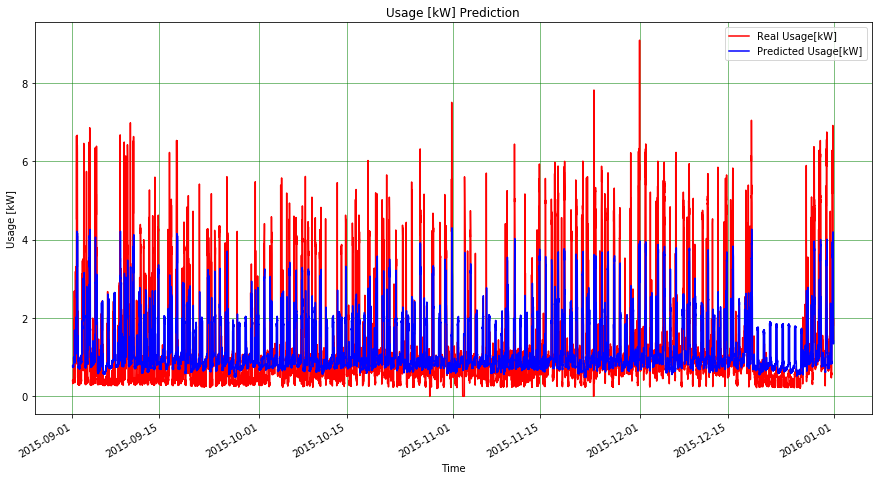

In [36]:
#我們可視化線性迴歸結果。
#測試集第一個data 2015-09-01 02:15:00
X_plt=New_power[New_power['Date & Time'].between('2015-09-01 02:15:00','2015-12-31 23:45:00')]
X_plt1=X_plt['Date & Time']

Y_pred= regressor.predict(X_test)

xs = [datetime.strptime(d,'%Y-%m-%d %H:%M:%S') for d in X_plt1]


years=mdates.YearLocator()
months=mdates.MonthLocator()
days=mdates.DayLocator()
hours = mdates.HourLocator()
minutes = mdates.MinuteLocator()
seconds = mdates.SecondLocator()

dateFmt = mdates.DateFormatter('%Y-%m')

fig = plt.figure()
ax.xaxis.set_major_locator(days)  # 设置主要刻度
ax.xaxis.set_minor_locator(hours)  # 设置主要刻度
ax.xaxis.set_major_formatter(dateFmt)  # 刻度标志格式

plt.figure(figsize=(15,8))
plt.plot(xs,Y_test, color = 'red', label = 'Real Usage[kW]')  # 紅線表示Usage
plt.plot(xs,Y_pred, color = 'blue', label = 'Predicted Usage[kW]')  # 藍線表示預測Usage
plt.title('Usage [kW] Prediction')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.xlabel('Time')
plt.ylabel('Usage [kW]')
plt.legend()
plt.gcf().autofmt_xdate() 
plt.show()


<Figure size 432x288 with 0 Axes>

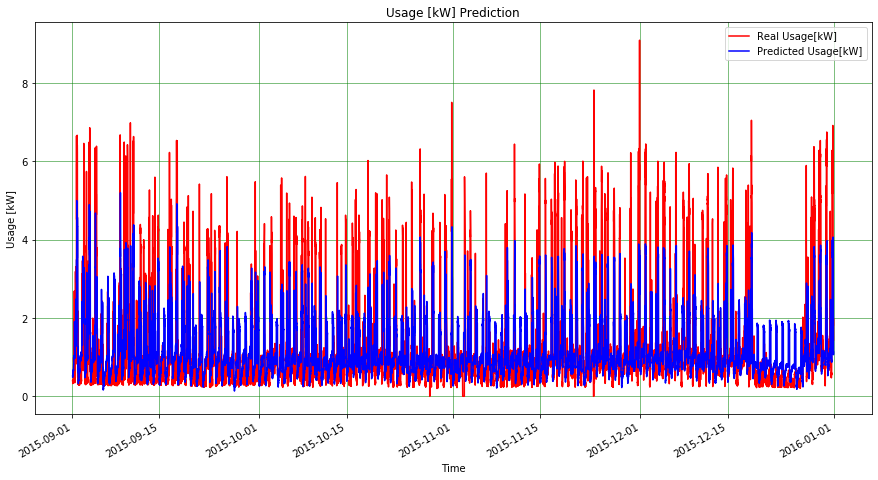

In [37]:
# 可視化多項式迴歸結果。 
Y_pred2=regressor2.predict(poly.fit_transform(X_test))

X_plt=New_power[New_power['Date & Time'].between('2015-09-01 02:15:00','2015-12-31 23:45:00')]
X_plt1=X_plt['Date & Time']

Y_pred= regressor.predict(X_test)

xs = [datetime.strptime(d,'%Y-%m-%d %H:%M:%S') for d in X_plt1]

years=mdates.YearLocator()
months=mdates.MonthLocator()
days=mdates.DayLocator()
hours = mdates.HourLocator()
minutes = mdates.MinuteLocator()
seconds = mdates.SecondLocator()
dateFmt = mdates.DateFormatter('%Y-%m')


fig = plt.figure()
ax.xaxis.set_major_locator(days)  # 设置主要刻度
ax.xaxis.set_minor_locator(hours)  # 设置主要刻度
ax.xaxis.set_major_formatter(dateFmt)  # 刻度标志格式

plt.figure(figsize=(15,8))
plt.plot(xs,Y_test, color = 'red', label = 'Real Usage[kW]')  # 紅線表示Usage
plt.plot(xs,Y_pred2, color = 'blue', label = 'Predicted Usage[kW]')  # 藍線表示預測Usage
plt.title('Usage [kW] Prediction')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.xlabel('Time')
plt.ylabel('Usage [kW]')
plt.legend()
plt.gcf().autofmt_xdate() 
plt.show()

In [ ]:
#平均絕對誤差(MAE)、均方誤差(MSE)、均方根誤差(RMSE)
print('linear:')
print('*Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))
print(' ')  
print('檢查準確度(%): ',regressor.score(X_train, Y_train)*100)

In [ ]:
#平均絕對誤差(MAE)、均方誤差(MSE)、均方根誤差(RMSE)
print('polynomial:')
print('*Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_pred2))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred2))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred2)))